In [3]:
import os
import math
import time
import argparse
import h5py
from tqdm import tqdm
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from biggan import (BigGAN, one_hot_from_names, one_hot_from_int, truncated_noise_sample,
                                       save_as_images, display_in_terminal, convert_to_images)

In [4]:
device = torch.device('cuda')
generator = BigGAN.from_pretrained('biggan-deep-512').to(device)

In [5]:
samples_data = h5py.File('gan_samples.hdf5', 'r')
samples_data_labels = h5py.File('gan_samples_labels.hdf5', 'r')
with open('./feature_direction.pkl', 'rb') as file:
    feature_slope = pickle.load(file)

In [6]:
norms = np.linalg.norm(feature_slope, ord=2, axis=0)

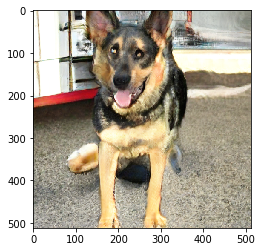

In [59]:
g_input_shape = 128
batch_size = 7
imagenet_class = 235

latents_c = truncated_noise_sample(truncation=0.7, batch_size=1)

class_vector = torch.from_numpy(one_hot_from_int(imagenet_class, batch_size=batch_size)).to(device)
output = generator(torch.from_numpy(latents_c).to(device), class_vector[0].unsqueeze(0), 0.7)
output = output.permute(0, 2, 3, 1)
output = (((output + 1) / 2.0) * 256 ).round().clamp(0, 255)
original_image = output.squeeze(0).detach().cpu().numpy().astype(np.uint8)

plt.imshow(original_image.astype(np.uint8))

In [76]:
i_feature = 131
actual_feature = i_feature-1
print('feature norm', norms[actual_feature])

latents_0 = latents_c - feature_slope[:, actual_feature][None, :]*1
latents_1 = latents_c + feature_slope[:, actual_feature][None, :]*1
latents = np.random.randn(batch_size, g_input_shape)
for i_alpha, alpha in enumerate(np.linspace(0, 1, batch_size)):
    latents[i_alpha, :] = latents_0[0]*(1-alpha) + latents_1[0]*alpha

noise_vector = torch.from_numpy(latents).float().to(device)

IndexError: index 130 is out of bounds for axis 0 with size 130

In [62]:
images = np.zeros((noise_vector.shape[0], 512, 512, 3))
with torch.no_grad():
    for i in tqdm(range(noise_vector.shape[0])):
        noise_v = noise_vector[i].unsqueeze(0)
        output = generator(noise_v, class_vector[i].unsqueeze(0), 0.7)
        output = output.permute(0, 2, 3, 1)
        output = (((output + 1) / 2.0) * 256 ).round().clamp(0, 255)
        images[i] = output.squeeze(0).cpu().numpy().astype(np.uint8)
print(images.shape)

100%|██████████| 7/7 [00:01<00:00,  4.11it/s]

(7, 512, 512, 3)


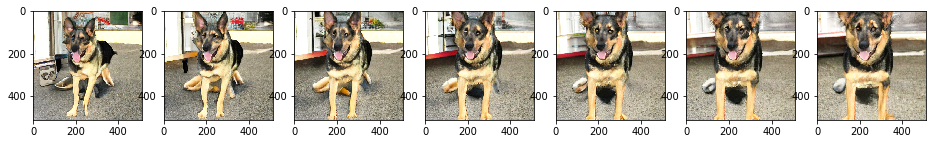

In [63]:
fig = plt.figure(figsize=(16, 5))
cols = 7
rows = 1

for i, image in enumerate(images):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image.astype(np.uint8))
plt.show()

In [49]:
import matplotlib
foldername = 'dognoears_zoom_2'
filename = 'dognoears_zoom_2'
if not os.path.exists(filename):
    os.mkdir(filename)
pickle.dump( latents_c, open( './{}/{}_latent.pkl'.format(foldername, filename), "wb" ) )
matplotlib.image.imsave('./{}/{}_original.jpg'.format(foldername, filename), 256. - original_image.astype(np.uint8))
for i, image in enumerate(images):
    matplotlib.image.imsave('./{}/{}_{}.jpg'.format(foldername, filename ,i), 256. - image)

In [75]:
print(norms)
print(len(norms))

[1.         1.                nan        nan 1.0000001  1.
 0.99999994 1.                nan        nan 1.                nan
 0.9999999         nan 1.         1.                nan        nan
        nan 1.                nan        nan 1.         0.99999994
        nan 1.         1.         1.         1.         1.
 0.99999994        nan 0.99999994        nan 1.                nan
        nan        nan 0.99999994 0.99999994 0.99999994 1.
 1.         1.         1.                nan 1.         1.
 1.                nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan 1.         1.                nan 1.         1.
        nan 1.         0.99999994        nan 1.                nan
 1.         1.                nan 1.         1.         0.99999994
 1.         0.99999994 1.         1.                nan 1.
        nan 1.         1.         0.99999994 0.99999994 1.
 0.99999994 0.99999994 1.         0.99999994 0.9999